In [1]:
import numpy as np
import os, glob
import matplotlib.pyplot as plt
plt.rc("font",size=14)

from netCDF4 import Dataset
import xarray, wrf

from pandas import to_datetime
from scipy.signal import welch
from matplotlib.cm import get_cmap
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature

In [2]:
plt.rc("font",size=14)

In [3]:
from scipy import fftpack

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
height = 100.0

In [6]:
dx = {"MYNN":333.0,
       "SH":333.0,
       "VLES":333.0,
       "YSU":333.0,
       "LES_25":25.0,
       "LES_100":100.0}

In [7]:
colors = {25:'k',100:'b',333:'r'}
colors = {"LES_25":"k","LES_100":"b","MYNN":"#FFC300","SH":"#FF5733","YSU":"#C70039","VLES":"#900C3F"}

In [42]:
directories = {"MYNN":"/glade/scratch/doubrawa/final_data/mynn/032815/",
               "SH":"/glade/scratch/doubrawa/final_data/sh/032815/",
               "VLES":"/glade/scratch/doubrawa/final_data/vles/032815/",
               "YSU":"/glade/scratch/doubrawa/final_data/ysu/032815/",
               "LES_25":"/glade/scratch/doubrawa/post_processing/"}
#                "LES_100":"/glade/scratch/doubrawa/post_processing/"}

In [8]:
figPath = "/glade/u/home/doubrawa/figs/"

### define a time

In [9]:
year     = 2015
month    = 3
day      = 28
hour     = 17
minute   = 30

In [11]:
datetime = to_datetime("{0}-{1}-{2} {3}:{4}".format(year,month,day,hour,minute),format="%Y-%m-%d %H:%M")

### read in the simulations I ran

w     = {}
xlat  = {}
xlong = {}

for key,directory in directories.items():

    if "LES_" not in key:

        print ("**********************************")
        print (key)

        wrfouts = sorted(glob.glob(os.path.join(directory,'wrfout_d03*')))
        ifile   = 0
        for wrfout in wrfouts:
            # from the file name, figure out what time these data are for
            time = to_datetime(wrfout.split("_d03_")[-1],format="%Y-%m-%d_%H:%M:%S")

            # only proceed if after 1400 UTC (1200-1400 is spin up)
            if ((time-datetime).seconds < 5 * 60.0):
                print (os.path.split(wrfout)[-1])

                wrfnc = Dataset(wrfout)

                #
                # these are needed for vertical interpolation
                #
                if ifile==0:
                    hgt  = wrf.getvar(wrfnc, "ter", units="m")
                    z    = wrf.getvar(wrfnc, "z", units="m")
                    zref = z-hgt

                w_3d = wrf.getvar(wrfnc, "wa", units="m s-1", timeidx=wrf.ALL_TIMES)
                w_2d = wrf.interplevel(w_3d, zref, height, meta=True)    

                if ifile==0:
                    w[key] = w_2d
                else:
                    w[key] = xarray.concat([w[key], w_2d], dim='Time')

                if ifile==0:
                    xlat[key]  = wrf.getvar(wrfnc, "lat")
                    xlong[key] = wrf.getvar(wrfnc, "lon")

                ifile += 1

**********************************
MYNN
wrfout_d03_2015-03-28_17:30:00
**********************************
SH
wrfout_d03_2015-03-28_17:30:00
**********************************
VLES
wrfout_d03_2015-03-28_17:30:00
**********************************
YSU
wrfout_d03_2015-03-28_17:30:00


In [33]:
### read in the simulations Domingo ran

for key,directory in directories.items():

    if "LES_" in key:

        print ("**********************************")
        print (key)

        wrfouts = sorted(glob.glob(os.path.join(directory,'WRF_{0}m_{2}*2015-03-{1}*.nc'.format(key,day,height))))
        ifile   = 0
        for wrfout in wrfouts:

            wrfnc = xarray.open_dataset(wrfout)
            time  = to_datetime(wrfnc.time[0].data)

            if ((time-datetime).seconds < 5 * 60.0):         

                print(wrfout)
                
                if ifile==0:
                    w[key] = wrfnc["w"]
                else:
                    w[key] = xarray.concat([w[key], wrfnc["w"]], dim='time')

                if ifile==0:
                    xlat[key]  = wrfnc["lat"]
                    xlong[key] = wrfnc["lon"]

                ifile += 1        

**********************************
LES_25
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_100.0_m_AGL_2015-03-28_17:30.nc
**********************************
LES_100


In [34]:
for key in ["MYNN","YSU","SH","VLES"]:
    w[key]["time"] = w[key]["Time"]
    w[key] = w[key].expand_dims('time')

LES_25
LES_100
Skipping LES_100
VLES
MYNN
YSU
SH


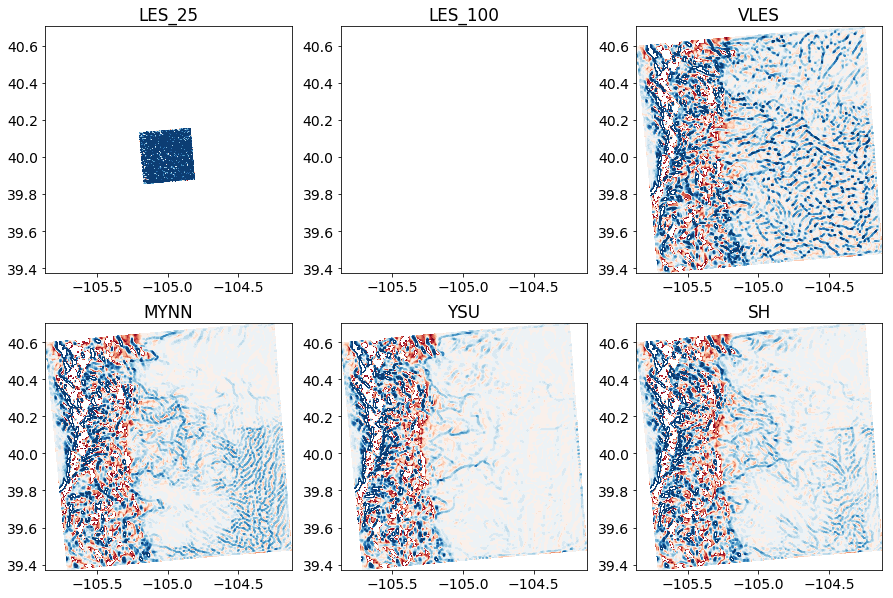

In [37]:
### plot each simulation method, just to make sure it's all there

levels = np.arange(-1.0,1.1,0.1)

fig = plt.figure(figsize=(15,10))

ax  = {}
for iax,key in enumerate(["LES_25","LES_100","VLES","MYNN","YSU","SH"]):

    print (key)

    if iax==0:
        ax[iax] = fig.add_subplot(2,3,iax+1)
    else:
        ax[iax] = fig.add_subplot(2,3,iax+1,sharex=ax[0],sharey=ax[0])
    ax[iax].set_title(key)

    try:
        contour = w[key].sel(time=datetime)
        lat = xlat[key]
        lon = xlong[key]

        ax[iax].contourf(lon,lat,contour,levels=levels,cmap="RdBu")        
    except:
        print("Skipping {0}".format(key))
#         datetimes_available = w[key]["time"]
#         dt_offsets = np.asarray([ (to_datetime(a)-datetime).seconds for a in datetimes_available.data])
#         if (np.min(dt_offsets) < 60.0):
#             idx   = np.argmin(dt_offsets)
#             avail = to_datetime(datetimes_available.data[idx])
#             contour = w[key].sel(time=avail)
#             print ("Couldn't find {0:%Y-%m-%d %H:%M:%S}, settling for {1:%Y-%m-%d %H:%M:%S}".format(datetime,avail))



# fig.savefig(os.path.join(figPath,"contours_w_{0:%Y-%m-%d-%H-%M}.png".format(datetime)),bbox_to_inches="tight")        

In [43]:
### equivalent x/y coordinates across domains

x = {}
y = {}

ref_wrfnc = Dataset("/glade/scratch/doubrawa/final_data/les/032815/032815_14UTC/wrfout_d04_2015-03-28_14:00:00_0000")

for key in directories.keys():
    print (key)
    x[key], y[key] = wrf.ll_to_xy(ref_wrfnc, xlat[key], xlong[key])
    x[key]   = np.reshape(x[key].data,w[key].shape[1:])
    y[key]   = np.reshape(y[key].data,w[key].shape[1:])

MYNN
SH
VLES
YSU
LES_25


In [46]:
### clip all of them to the same area

xmin, xmax = np.min(x["LES_25"]), np.max(x["LES_25"])
ymin, ymax = np.min(y["LES_25"]), np.max(y["LES_25"])

x_clipped = {}
y_clipped = {}
w_clipped = {}

for key in ["MYNN","SH","YSU","VLES"]:

    print (key)

    condition_x = ( (x[key] >= xmin) & (x[key]<=xmax) )
    condition_y = ( (y[key] >= ymin) & (y[key]<=ymax) )
    condition   = condition_x & condition_y

    idx_sn, idx_we = np.where(condition)
    idx_sn = np.unique(idx_sn)
    idx_we = np.unique(idx_we)

    w_clipped[key] = (w[key].isel(west_east=idx_we,south_north=idx_sn)).copy()
    x_clipped[key] = (x[key][idx_sn,idx_we]).copy()
    y_clipped[key] = (y[key][idx_sn,idx_we]).copy()

x_clipped["LES_25"] = x["LES_25"]
y_clipped["LES_25"] = y["LES_25"]
w_clipped["LES_25"] = w["LES_25"]

MYNN
SH
YSU
VLES


In [47]:
levels = np.arange(-1.0,1.1,0.1)

LES_25
VLES
MYNN
YSU
SH


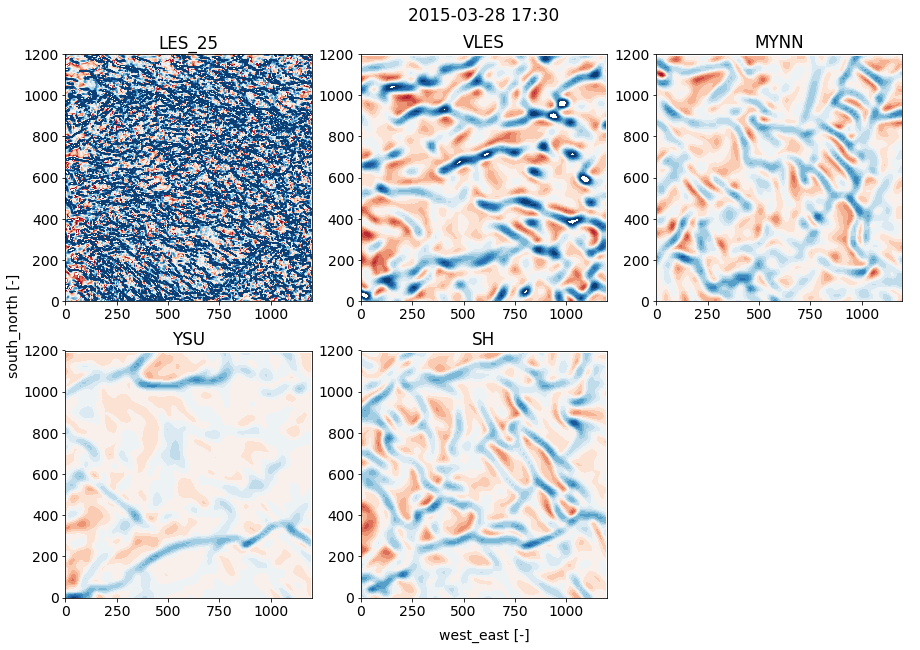

In [49]:
fig   = plt.figure(figsize=(15,10))

axbig = fig.add_subplot(111)
axbig.spines['top'].set_color('none')
axbig.spines['bottom'].set_color('none')
axbig.spines['left'].set_color('none')
axbig.spines['right'].set_color('none')
axbig.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
axbig.set_xlabel("west_east [-]",labelpad=10)
axbig.set_ylabel("south_north [-]",labelpad=15)
axbig.set_title("{0:%Y-%m-%d %H:%M}".format(datetime),y=1.05)

ax  = {}
for iax,key in enumerate(["LES_25","VLES","MYNN","YSU","SH"]):

    print(key)

    if iax==0:
        ax[iax] = fig.add_subplot(2,3,iax+1)
    else:
        ax[iax] = fig.add_subplot(2,3,iax+1,sharex=ax[0],sharey=ax[0])
    ax[iax].set_title(key)

    try:
        contour = w_clipped[key].sel(time=datetime)
    except:
        print("skipping...")
        datetimes_available = w_clipped[key]["time"]
        dt_offsets = np.asarray([ (to_datetime(a)-datetime).seconds for a in datetimes_available.data])
        if (np.min(dt_offsets) < 2*60.0):
            idx   = np.argmin(dt_offsets)
            avail = to_datetime(datetimes_available.data[idx])
            contour = w_clipped[key].sel(time=avail)
        print ("Couldn't find {0:%Y-%m-%d %H:%M:%S}, settling for {1:%Y-%m-%d %H:%M:%S}".format(datetime,avail))

    xx = x_clipped[key]
    yy = y_clipped[key]


    ax[iax].contourf(xx,yy,contour,levels=levels,cmap="RdBu")

    ax[iax].set_xlim([xmin,xmax])
    ax[iax].set_ylim([ymin,ymax])    

# fig.savefig(os.path.join(figPath,"contours_w_clipped_{0:%Y-%m-%d-%H-%M}.png".format(datetime)),bbox_to_inches="tight")    

In [50]:
w["LES_25"]

<xarray.DataArray 'w' (time: 1, south_north: 1200, west_east: 1200)>
[1440000 values with dtype=float64]
Coordinates:
  * south_north  (south_north) int64 0 1 2 3 4 5 ... 1195 1196 1197 1198 1199
  * west_east    (west_east) int64 0 1 2 3 4 5 ... 1194 1195 1196 1197 1198 1199
  * time         (time) datetime64[ns] 2015-03-28T17:30:00
    lat          (south_north, west_east) float64 39.85 39.85 ... 40.16 40.16
    lon          (south_north, west_east) float64 -105.2 -105.2 ... -104.8
    z            float64 ...
Attributes:
    stagger:     
    height [m]:  100.0
    unit:        m s-1
    level:       100.0

### compare their spectra -- 1-D

In [17]:
def make_axbig(fig,xlabel,ylabel,title):
    axbig = fig.add_subplot(111)
    axbig.spines['top'].set_color('none')
    axbig.spines['bottom'].set_color('none')
    axbig.spines['left'].set_color('none')
    axbig.spines['right'].set_color('none')
    axbig.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    axbig.set_xlabel(xlabel,labelpad=10)
    axbig.set_ylabel(ylabel,labelpad=15)
    axbig.set_title(title,y=1.1)    
    return axbig

In [18]:
def get_array_at_time(dictionary,key,datetime):
    try:
        contour = dictionary[key].sel(time=datetime)
    except:
        print("skipping...")
        datetimes_available = dictionary[key]["time"]
        dt_offsets = np.asarray([ (to_datetime(a)-datetime).seconds for a in datetimes_available.data])
        if (np.min(dt_offsets) < 2*60.0):
            idx   = np.argmin(dt_offsets)
            avail = to_datetime(datetimes_available.data[idx])
            contour = dictionary[key].sel(time=avail)
        print ("Couldn't find {0:%Y-%m-%d %H:%M:%S} for {2}, settling for {1:%Y-%m-%d %H:%M:%S}".format(datetime,avail,key))

    return contour.interpolate_na(dim='south_north').interpolate_na(dim='west_east')

In [19]:
def psd_1d_from_2d_field(var_2d, dx, segment_length=30000.0, psd_along_direction="west_east"):

    nseg    = segment_length/dx           
    
    if psd_along_direction=="south_north":

        n_west_east = len(var_2d.west_east)

        for i in range(n_west_east):

            x_south_north = var_2d.data[:,i]

            if i==0:
                ff, pp = np.abs(welch(x_south_north,fs=1/dx,nperseg=nseg))
            else:
                junk, now = np.abs(welch(x_south_north,fs=1/dx,nperseg=nseg))
                pp = pp + now

        pp = pp/float(n_west_east)

    else:
        
        n_south_north = len(var_2d.south_north)
    
        for i in range(n_south_north):

            x_west_east = xx.data[i,:]

            if i==0:
                ff, pp = np.abs(welch(x_west_east,fs=1/dx,nperseg=nseg))
            else:
                junk, now = np.abs(welch(x_west_east,fs=1/dx,nperseg=nseg))
                pp = pp + now

        pp = pp/float(n_south_north)
        
    return ff,pp

/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


skipping...
Couldn't find 2015-03-28 17:30:00, settling for 2015-03-28 17:30:10
skipping...
Couldn't find 2015-03-28 17:30:00, settling for 2015-03-28 17:31:00
skipping...
Couldn't find 2015-03-28 17:30:00, settling for 2015-03-28 17:30:10
skipping...
Couldn't find 2015-03-28 17:30:00, settling for 2015-03-28 17:31:00


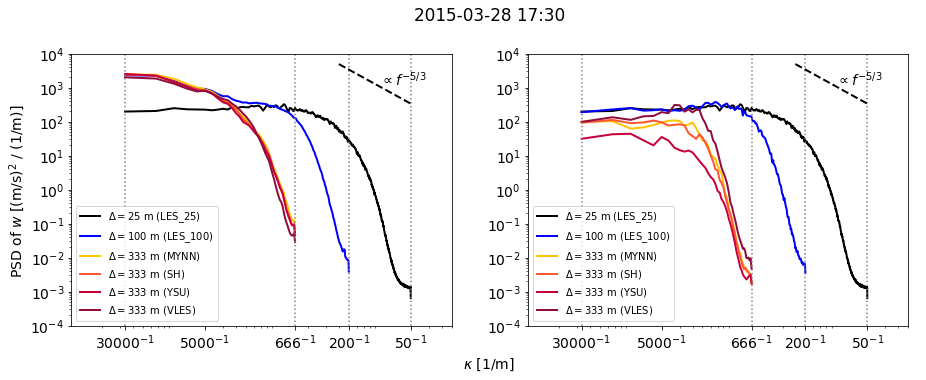

In [86]:
#
# along south_north direction
#

fig   = plt.figure(figsize=(15,5))
axbig = make_axbig(fig, xlabel="$\kappa$ [1/m] ", ylabel="PSD of $w$ [(m/s)$^{{2}}$ / (1/m)] ", title="{0:%Y-%m-%d %H:%M}".format(datetime))
ax    = {}

for iax,var in enumerate([w,w_clipped]):

    ax[iax]  = fig.add_subplot(1,2,iax+1)

    for key in ["LES_25","LES_100","MYNN","SH","YSU","VLES"]:

        xx = get_array_at_time(var,key,datetime)
        ff, psd = psd_1d_from_2d_field(xx, dx[key], psd_along_direction="south_north")
        label = "$\Delta={0:.0f}$ m ({1})".format(dx[key],key)
        ax[iax].loglog(ff[1:],psd[1:],lw=2,label=label,color=colors[key])   

    ax[iax].axvline(x=1/666.0,color='gray',linestyle=":")
    ax[iax].axvline(x=1/200.0,color='gray',linestyle=":")
    ax[iax].axvline(x=1/50.0,color='gray',linestyle=":")
    ax[iax].axvline(x=1/segment, color='gray',linestyle=":")

    ax[iax].set_xlim([1e-5,5e-2])
    ax[iax].set_ylim([1e-4,1e4])

    ref_f     = np.linspace(4e-3,2e-2,20)
    ref_slope = ref_f**(-5/3) * 5e-1
    ax[iax].loglog(ref_f,ref_slope,'--k',lw=2)
    ax[iax].text(1e-2,1.2e3,'$\propto f^{{-5/3}}$',horizontalalignment='left') 

    kappas = [50.,200.,666.,5000.0,30000.0]
    ax[iax].set_xticks([1/q for q in kappas])
    ax[iax].set_xticklabels([r"{0:.0f}$^{{-1}}$".format(q) for q in kappas])

    plt.legend(loc=3,fontsize=10)


# fig.savefig(os.path.join(figPath,"PSD_1d_w_along_south_north_{0:%Y-%m-%d-%H-%M}.png".format(datetime)),bbox_to_inches="tight")

/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


skipping...
Couldn't find 2015-03-28 17:30:00, settling for 2015-03-28 17:30:10
skipping...
Couldn't find 2015-03-28 17:30:00, settling for 2015-03-28 17:31:00
skipping...
Couldn't find 2015-03-28 17:30:00, settling for 2015-03-28 17:30:10
skipping...
Couldn't find 2015-03-28 17:30:00, settling for 2015-03-28 17:31:00


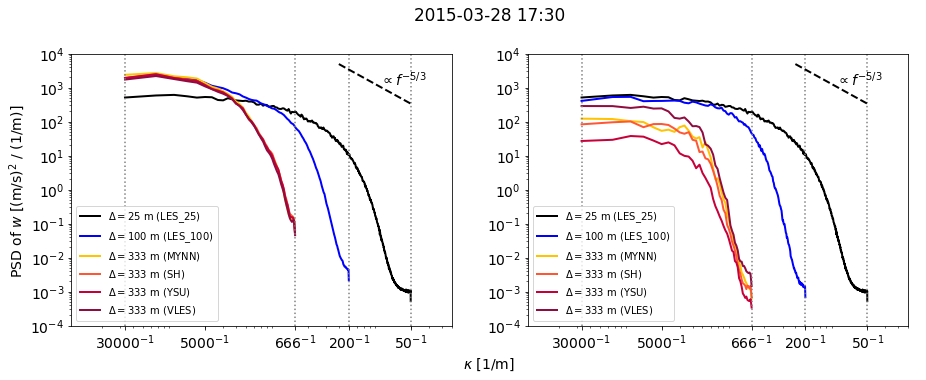

In [85]:
#
# along west_east direction
#

fig   = plt.figure(figsize=(15,5))
axbig = make_axbig(fig, xlabel="$\kappa$ [1/m] ", ylabel="PSD of $w$ [(m/s)$^{{2}}$ / (1/m)] ", title="{0:%Y-%m-%d %H:%M}".format(datetime))
ax    = {}

for iax,var in enumerate([w,w_clipped]):

    ax[iax]  = fig.add_subplot(1,2,iax+1)

    for key in ["LES_25","LES_100","MYNN","SH","YSU","VLES"]:

        xx = get_array_at_time(var,key,datetime)
        ff, psd = psd_1d_from_2d_field(xx, dx[key], psd_along_direction="west_east")
        label = "$\Delta={0:.0f}$ m ({1})".format(dx[key],key)
        ax[iax].loglog(ff[1:],psd[1:],lw=2,label=label,color=colors[key])   

    ax[iax].axvline(x=1/666.0,color='gray',linestyle=":")
    ax[iax].axvline(x=1/200.0,color='gray',linestyle=":")
    ax[iax].axvline(x=1/50.0,color='gray',linestyle=":")
    ax[iax].axvline(x=1/segment, color='gray',linestyle=":")

    ax[iax].set_xlim([1e-5,5e-2])
    ax[iax].set_ylim([1e-4,1e4])

    ref_f     = np.linspace(4e-3,2e-2,20)
    ref_slope = ref_f**(-5/3) * 5e-1
    ax[iax].loglog(ref_f,ref_slope,'--k',lw=2)
    ax[iax].text(1e-2,1.2e3,'$\propto f^{{-5/3}}$',horizontalalignment='left') 

    kappas = [50.,200.,666.,5000.0,30000.0]
    ax[iax].set_xticks([1/q for q in kappas])
    ax[iax].set_xticklabels([r"{0:.0f}$^{{-1}}$".format(q) for q in kappas])

    plt.legend(loc=3,fontsize=10)


# fig.savefig(os.path.join(figPath,"PSD_1d_w_along_south_north_{0:%Y-%m-%d-%H-%M}.png".format(datetime)),bbox_to_inches="tight")

# FILTER

In [20]:
v_array = {}

for key in w.keys():
    
    print (key)
    v_array[key] = get_array_at_time(w_clipped, key, datetime)

MYNN
SH
VLES
YSU
LES_25
skipping...
Couldn't find 2015-03-28 17:30:00 for LES_25, settling for 2015-03-28 17:30:10
LES_100
skipping...
Couldn't find 2015-03-28 17:30:00 for LES_100, settling for 2015-03-28 17:31:00


In [21]:
psd_2d      = {}
kappas_1d   = {}
kappas_j    = {}
kappas_i    = {}

for key in w.keys():
    psd_2d[key]                   = fftpack.fft2(v_array[key])
    kappas_1d[key]                = fftpack.fftfreq(len(v_array[key]),d=dx[key])
    [kappas_j[key],kappas_i[key]] = np.meshgrid(kappas_1d[key],kappas_1d[key])    
#     psd_2d[key] = fftpack.fft2(v_array[key], overwrite_x=False)
#     kappas[key] = fftpack.fftfreq(len(v_array[key]),d=dx[key])
#     kappas_2d[key] = np.meshgrid(kappas[key],kappas[key])
#     psd_2d_filt[key] = np.zeros(psd_2d[key].shape)

In [23]:
psd_2d_filt = {}

for key in w.keys():
    idx     = np.where( (np.abs(kappas_j[key])>f_cut) | (np.abs(kappas_i[key])>f_cut) )
    psd_2d_filt[key] = psd_2d[key].copy()
    psd_2d_filt[key][idx] = 0.0+0j

In [24]:
# filter_mask = {}
# for key in w.keys():
#     filter_mask[key]   = np.zeros(psd_2d[key].shape)
#     idx_i, idx_j       = np.where( (np.abs(kappas_2d[key][0])<f_cut)&(np.abs(kappas_2d[key][1])<f_cut) )
#     filter_mask[key][idx_i,idx_j] = 1.0
#     psd_2d_filt[key] = psd_2d[key] * filter_mask[key]

/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log10


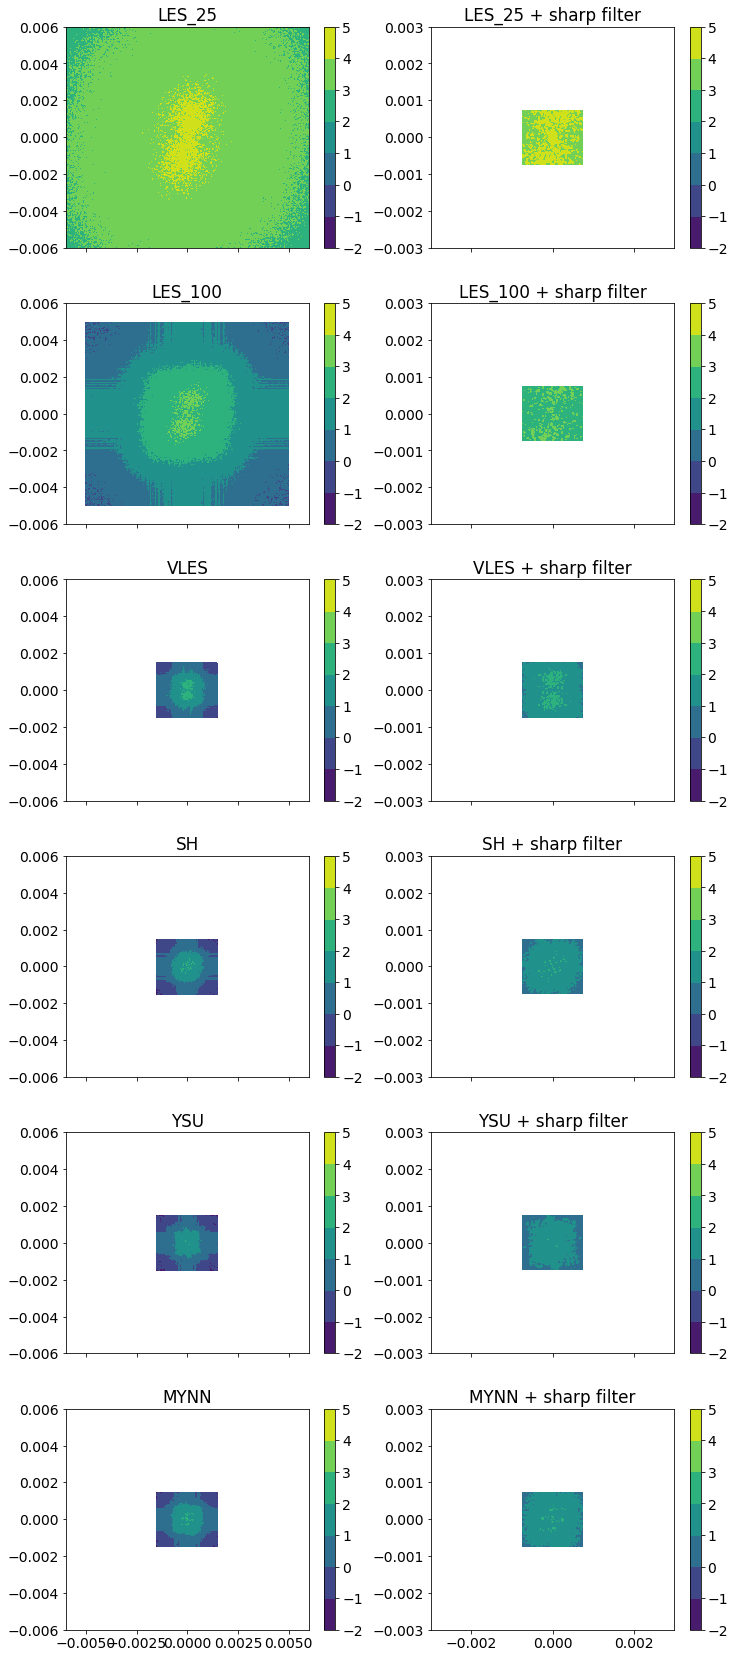

In [24]:
keys  = ["LES_25","LES_100","VLES","SH","YSU","MYNN"]
nkeys = len(keys)

fig = plt.figure(figsize=(2*6,nkeys*5*2))
ax  = {}

iax = 1
for ikey,key in enumerate(keys):
    
    if iax==1:
        ax[iax] = fig.add_subplot(2*nkeys,2,iax)
    else:
        ax[iax] = fig.add_subplot(2*nkeys,2,iax,sharex=ax[1],sharey=ax[1])
    ax[iax].set_title(key) 
    
    p = ax[iax].contourf( np.sort(kappas_1d[key]), 
                          np.sort(kappas_1d[key]), 
                          np.log10(np.abs(fftpack.fftshift(psd_2d[key]))),
                          levels=np.arange(-2,5.1,1))

    plt.colorbar(p)
    ax[iax].set_xlim([-0.006,0.006])
    ax[iax].set_ylim([-0.006,0.006])        
    
    if (iax<(nkeys*2-1)):
        plt.setp(ax[iax].get_xticklabels(), visible=False)    
    
    iax += 1
    
    if iax==2:
        ax[iax] = fig.add_subplot(2*nkeys,2,iax)
    else:
        ax[iax] = fig.add_subplot(2*nkeys,2,iax,sharex=ax[2],sharey=ax[2])        
    
    ax[iax].set_title(key+" + sharp filter")
    p = ax[iax].contourf( np.sort(kappas_1d[key]), 
                          np.sort(kappas_1d[key]), 
                          np.log10(np.abs(fftpack.fftshift(psd_2d_filt[key]))),
                          levels=np.arange(-2,5.1,1))  
    
    ax[iax].set_xlim([-0.003,0.003])
    ax[iax].set_ylim([-0.003,0.003])  
    
    plt.colorbar(p)
    if (iax<(nkeys*2-1)):
        plt.setp(ax[iax].get_xticklabels(), visible=False)    
        
    iax += 1

fig.subplots_adjust(hspace=0.25)

In [25]:
v_array_filt = {}
for key in w.keys():
#     v_array_filt[key] = (fftpack.ifft2(psd_2d_filt[key]))
    v_array_filt[key] = fftpack.ifft2(psd_2d_filt[key])

/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/numpy/ma/core.py:2785: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


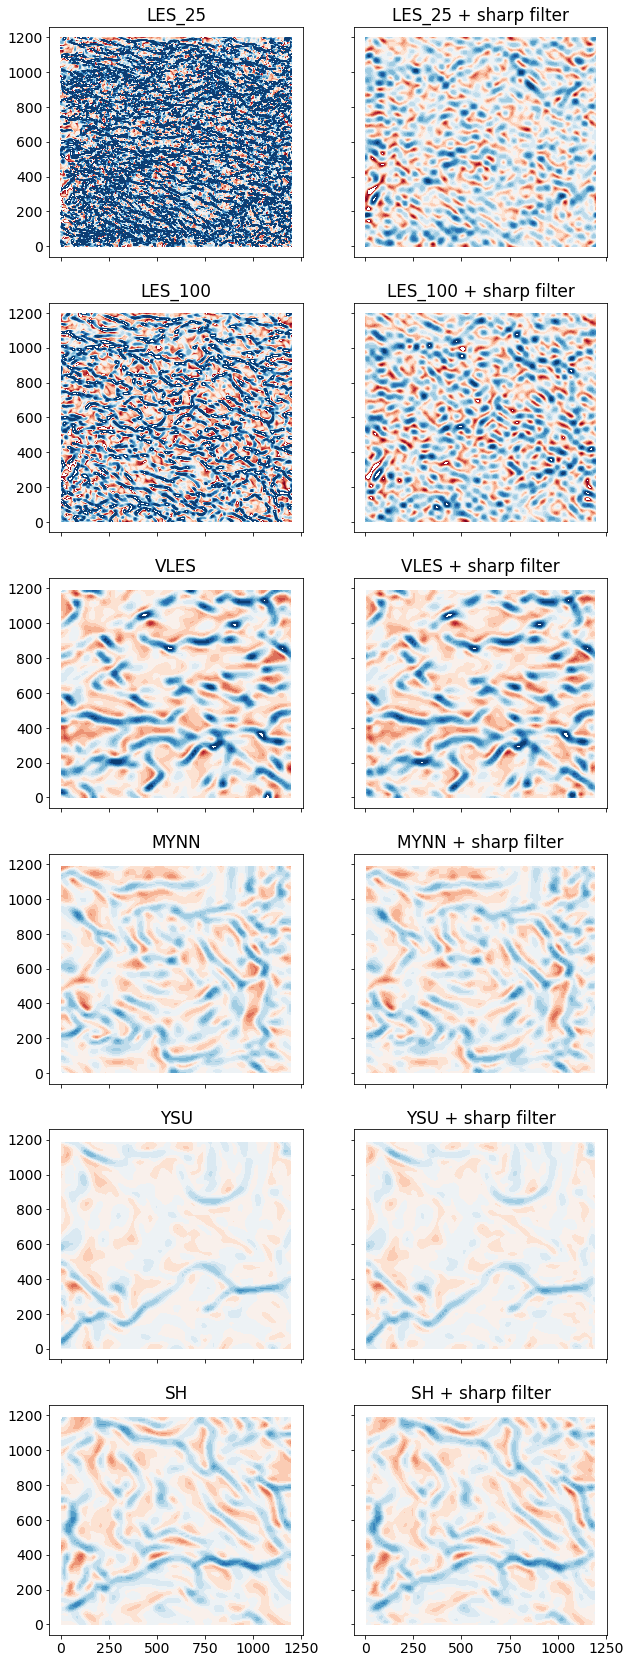

In [58]:
keys  = ["LES_25","LES_100","VLES","SH","YSU","MYNN"]
nkeys = len(keys)

fig = plt.figure(figsize=(2*5,nkeys*5*2))
ax  = {}

iax = 1
for ikey,key in enumerate(["LES_25","LES_100","VLES","MYNN","YSU","SH"]):
    
    if iax==1:
        ax[iax] = fig.add_subplot(2*nkeys,2,iax)
    else:
        ax[iax] = fig.add_subplot(2*nkeys,2,iax,sharex=ax[1],sharey=ax[1])
    ax[iax].set_title(key) 
    
    ax[iax].contourf( x_clipped[key], 
                      y_clipped[key], 
                      v_array[key],
                      levels=levels,
                      cmap="RdBu")

    if (iax<(nkeys*2-1)):
        plt.setp(ax[iax].get_xticklabels(), visible=False)    
    
    iax += 1
    
    ax[iax] = fig.add_subplot(2*nkeys,2,iax,sharex=ax[1],sharey=ax[1])
    ax[iax].set_title(key+" + sharp filter")

    ax[iax].contourf( x_clipped[key], 
                      y_clipped[key], 
                      v_array_filt[key],
                     levels=levels,
                     cmap="RdBu")       
    
    if np.mod(iax,2.)==0:
        plt.setp(ax[iax].get_yticklabels(), visible=False)
    if (iax<(nkeys*2-1)):
        plt.setp(ax[iax].get_xticklabels(), visible=False)    
        
    iax += 1
    
fig.subplots_adjust()
# fig.savefig(os.path.join(figPath,"contours_w_clipped_filtered_{0:%Y-%m-%d-%H-%M}.png".format(datetime)),bbox_to_inches="tight")    

/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


LES_25
LES_100
VLES
MYNN
YSU
SH


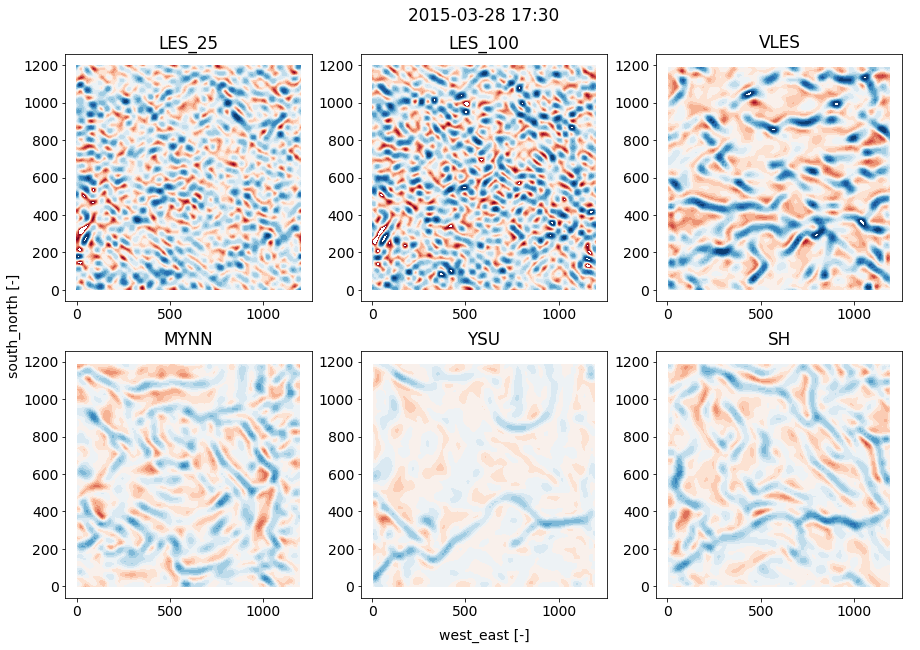

In [60]:
levels = np.arange(-1.0,1.1,0.1)
keys  = ["LES_25","LES_100","VLES","SH","YSU","MYNN"]
nkeys = len(keys)

fig = plt.figure(figsize=(15,10))

axbig = fig.add_subplot(111)
axbig.spines['top'].set_color('none')
axbig.spines['bottom'].set_color('none')
axbig.spines['left'].set_color('none')
axbig.spines['right'].set_color('none')
axbig.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
axbig.set_xlabel("west_east [-]",labelpad=10)
axbig.set_ylabel("south_north [-]",labelpad=15)
axbig.set_title("{0:%Y-%m-%d %H:%M}".format(datetime),y=1.05)

ax  = {}
for iax,key in enumerate(["LES_25","LES_100","VLES","MYNN","YSU","SH"]):

    print (key)

    if iax==0:
        ax[iax] = fig.add_subplot(2,3,iax+1)
    else:
        ax[iax] = fig.add_subplot(2,3,iax+1,sharex=ax[0],sharey=ax[0])
    ax[iax].set_title(key)
    
    ax[iax].contourf( x_clipped[key], 
                      y_clipped[key], 
                      v_array_filt[key],
                      levels=levels,
                      cmap="RdBu")

    
fig.subplots_adjust()
fig.savefig(os.path.join(figPath,"contours_w_clipped_filtered_{0:%Y-%m-%d-%H-%M}.png".format(datetime)),bbox_to_inches="tight")    

# JUNKYARD (CHECK FILTERING)

/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


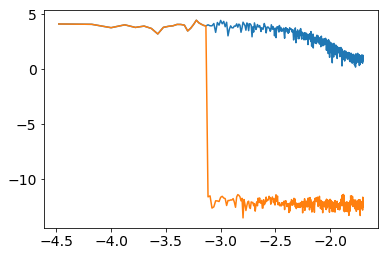

In [28]:
key = "LES_25"

fig = plt.figure()
ax  = fig.add_subplot(111)

x = v_array[key].copy()
p = fftpack.fft2(x)

x2 = v_array_filt[key].copy()
p2 = fftpack.fft2(x2)

f = fftpack.fftfreq(len(x2),dx[key])

ax.plot( np.log10(f) , np.log10(np.abs(p[:,2])) )
ax.plot( np.log10(f) , np.log10(np.abs(p2[:,2])) )

/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


skipping...
Couldn't find 2015-03-28 17:30:00 for LES_25, settling for 2015-03-28 17:30:10


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log10


skipping...
Couldn't find 2015-03-28 17:30:00 for LES_100, settling for 2015-03-28 17:31:00


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log10
/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log10
/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log10
/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/ipykernel_launcher.py:22

skipping...
Couldn't find 2015-03-28 17:30:00 for LES_25, settling for 2015-03-28 17:30:10


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log10
/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log10
/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log10
/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/ipykernel_launcher.py:22

skipping...
Couldn't find 2015-03-28 17:30:00 for LES_100, settling for 2015-03-28 17:31:00
LES_25
21867844.139659937
LES_100
1684589.5446118983
MYNN
74829.375
SH
65681.375
YSU
39050.723
VLES
110341.73


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log10
/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in log10


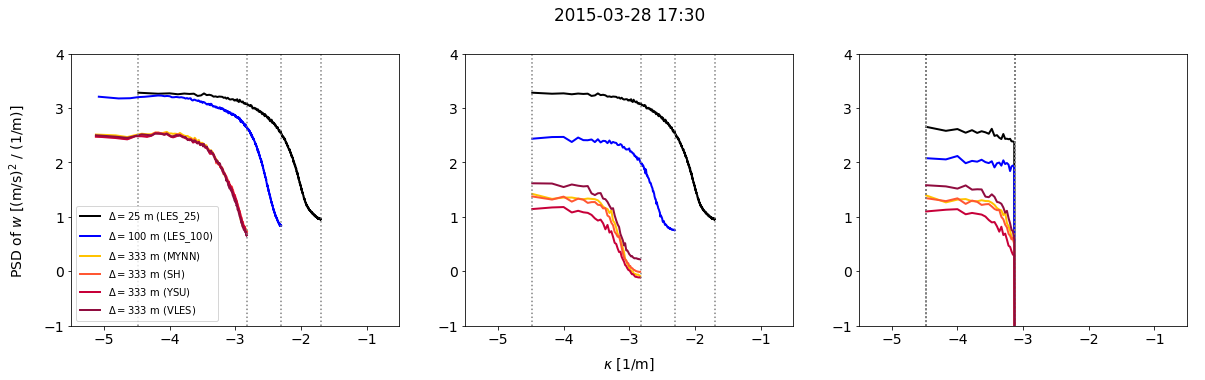

In [52]:
segment = 30000.0

#
# along west_east direction
#


fig   = plt.figure(figsize=(20,5))
axbig = make_axbig(fig, xlabel="$\kappa$ [1/m] ", ylabel="PSD of $w$ [(m/s)$^{{2}}$ / (1/m)] ", title="{0:%Y-%m-%d %H:%M}".format(datetime))
ax    = {}

for iax,var in enumerate([w,w_clipped]):

    ax[iax]  = fig.add_subplot(1,3,iax+1)

    for key in ["LES_25","LES_100","MYNN","SH","YSU","VLES"]:

        xx    = get_array_at_time(var,key,datetime)
        ff    = fftpack.fftfreq(len(xx),d=dx[key])
        psd   = np.mean(np.abs(fftpack.fft2(xx)),axis=0)
        label = "$\Delta={0:.0f}$ m ({1})".format(dx[key],key)
        ax[iax].plot(np.log10(ff),np.log10(psd),lw=2,label=label,color=colors[key])   

    ax[iax].axvline(x=np.log10(1/666.0),color='gray',linestyle=":")
    ax[iax].axvline(x=np.log10(1/200.0),color='gray',linestyle=":")
    ax[iax].axvline(x=np.log10(1/50.0),color='gray',linestyle=":")
    ax[iax].axvline(x=np.log10(1/segment), color='gray',linestyle=":")

    ax[iax].set_ylim([-1.0, 4.0])
    ax[iax].set_xlim([-5.5,-0.5])

#     ref_f     = np.linspace(4e-3,2e-2,20)
#     ref_slope = ref_f**(-5/3) * 5e-1
#     ax[iax].loglog(np.log10(ref_f),np.log10(ref_slope),'--k',lw=2)
#     ax[iax].text(1e-2,1.2e3,'$\propto f^{{-5/3}}$',horizontalalignment='left') 

#     kappas = [50.,200.,666.,5000.0,30000.0]
#     ax[iax].set_xticks([1/q for q in kappas])
#     ax[iax].set_xticklabels([r"{0:.0f}$^{{-1}}$".format(q) for q in kappas])

    if iax==0:
        plt.legend(loc=3,fontsize=10)

ax3 = fig.add_subplot(1,3,3,sharex=ax[0],sharey=ax[0])

for key in ["LES_25","LES_100","MYNN","SH","YSU","VLES"]:

    print (key)
    nseg = segment/float(dx[key])
    
    psd_before = psd_2d_filt[key]
    
    xx         = v_array_filt[key]
    ff         = fftpack.fftfreq(len(xx),d=dx[key])
    psd        = np.abs(fftpack.fft2(xx))
    psd_mean   = np.mean(psd,axis=0)
    
    print (np.sum(np.abs(psd-psd_before)))
    
    ax3.axvline(x=np.log10(1/segment), color='gray',linestyle=":")
    ax3.axvline(x=np.log10(f_cut), color='gray',linestyle=":")    
    ax3.plot(np.log10(ff),np.log10(psd_mean),lw=2,label=label,color=colors[key])   

# fig.savefig(os.path.join(figPath,"PSD_1d_w_along_west_east_{0:%Y-%m-%d-%H-%M}.png".format(datetime)),bbox_to_inches="tight")

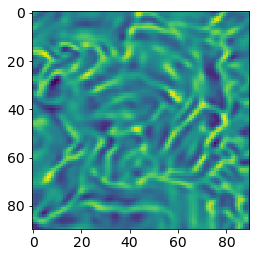

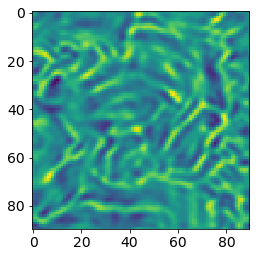

In [27]:
key = "MYNN"

x_before = get_array_at_time(w_clipped,key,datetime).data
x_after  = v_array_filt[key]

plt.figure()
plt.imshow(x_before)

plt.figure()
plt.imshow(x_after)

In [417]:
key="LES_25"
x = get_array_at_time(w_clipped,key,datetime)

skipping...
Couldn't find 2015-03-28 17:30:00 for LES_25, settling for 2015-03-28 17:30:10


In [418]:
x_data = x.data

In [421]:
np.save("LES_25_w.npy",x_data)

In [400]:
psd             = fftpack.fft2(x_data, overwrite_x=False)
fre_1d          = fftpack.fftfreq(len(x_data),d=dx[key])

psd_abs         = np.abs(psd)
psd_shifted     = fftpack.fftshift(psd)
psd_abs_shifted = fftpack.fftshift(psd_abs)

In [401]:
[fre_x,fre_y] = np.meshgrid(np.sort(fre_1d),np.sort(fre_1d))

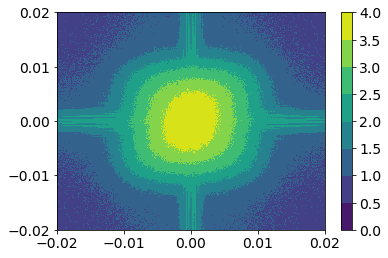

In [402]:
plt.contourf(np.sort(fre_1d),np.sort(fre_1d),np.log10(np.abs(psd_shifted)),levels=np.arange(0,4.1,0.5));plt.colorbar()

In [403]:
idx = np.where( (np.abs(fre_x)>0.001) | (np.abs(fre_y)>0.001) )

In [404]:
psd_shifted_inv = psd_shifted.copy()
psd_shifted_inv[idx] = 0.0

/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


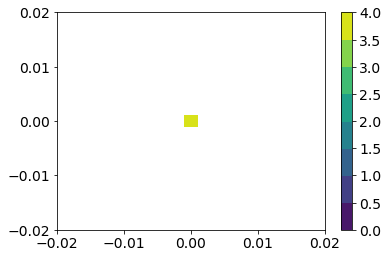

In [405]:
plt.contourf(np.sort(fre_1d),np.sort(fre_1d),np.log10(np.abs(psd_shifted_inv)),levels=np.arange(0,4.1,0.5));plt.colorbar()

/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


inf


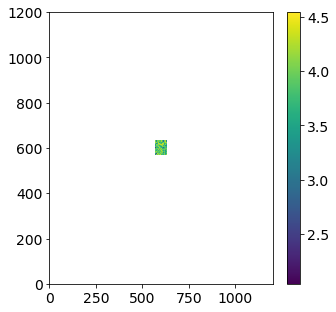

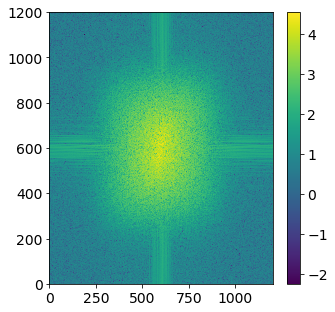

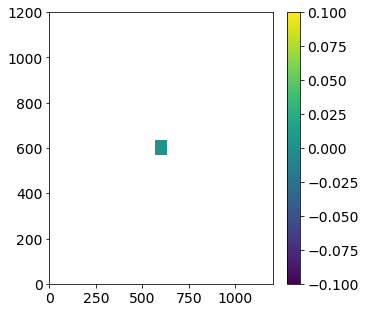

In [406]:
plt.figure(figsize=(5,5))
plt.pcolormesh(np.log10(np.abs(psd_shifted_inv)))
plt.colorbar()
plt.figure(figsize=(5,5))
plt.pcolormesh(np.log10(np.abs(psd_shifted)))
plt.colorbar()
plt.figure(figsize=(5,5))
diff = np.log10(np.abs(psd_shifted_inv)) - np.log10(np.abs(psd_shifted))
print (np.max(np.abs(diff)))
plt.pcolormesh(diff)
plt.colorbar()

In [409]:
psd_inv = fftpack.ifftshift(psd_shifted_inv)

In [410]:
x_data_inv = fftpack.ifft2(psd_inv).real

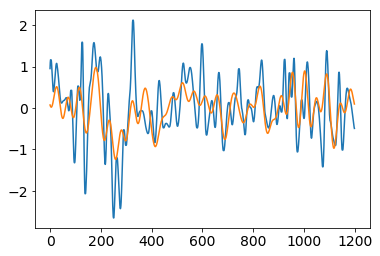

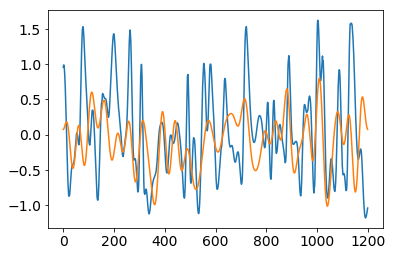

In [411]:
plt.figure()
plt.plot(x_data[:,0])
plt.plot(x_data_inv[:,0])

plt.figure()
plt.plot(x_data[0,:])
plt.plot(x_data_inv[0,:])

In [412]:
#     x_before = get_array_at_time(w_clipped,key,datetime).data
#     x_after  = v_array_filt[key]
x_before = x_data
x_after = x_data_inv

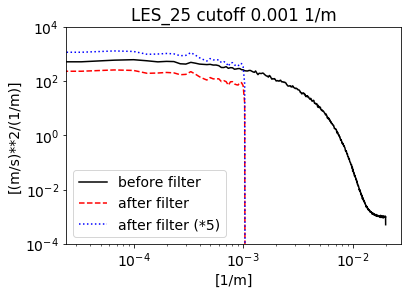

In [416]:
nseg = 30000/float(dx[key])

nj, ni = x_before.shape
for j in range(nj):
    x_tmp = x_before[j,:]
    if j==0:
        f_before, p_before = np.abs(welch(x_tmp,fs=1/dx[key],nperseg=nseg))
    else:
        junk, p_tmp = np.abs(welch(x_tmp,fs=1/dx[key],nperseg=nseg))
        p_before += p_tmp
p_before /= float(nj)    

nj, ni = x_after.shape
for j in range(nj):
    x_tmp = x_after[j,:]
    if j==0:
        f_after, p_after = np.abs(welch(x_tmp,fs=1/dx[key],nperseg=nseg))
    else:
        junk, p_tmp = np.abs(welch(x_tmp,fs=1/dx[key],nperseg=nseg))
        p_after += p_tmp
p_after /= float(nj)

plt.figure()
plt.loglog(f_before,p_before,'-k',label='before filter')
plt.loglog(f_after,p_after,'--r',label='after filter')
plt.loglog(f_after,p_after*5,':b',label='after filter (*5)')
plt.title(key+" cutoff 0.001 1/m")
plt.ylim([1e-4,1e4])
plt.xlabel("[1/m]")
plt.ylabel("[(m/s)**2/(1/m)]")
plt.legend()

In [65]:
aa=np.random.randn(30)

In [66]:
aa

array([ 1.99166471, -0.68297694,  0.36473294,  0.55669195, -0.55579791,
        0.16498631,  1.44820171, -0.17463606, -2.83200907, -0.42244293,
       -0.57986819,  0.4677491 ,  1.04435444,  0.0766284 , -1.11427532,
        0.46598051,  0.53549856, -0.21480373, -0.4699734 , -1.12424881,
        0.94408346,  0.56977685, -0.52829177,  0.19496767, -1.06601306,
        1.16665753,  0.56566065, -0.93335598, -0.0855441 , -0.30508446])

In [71]:
np.mean([np.mean(aa[0:10]) , np.mean(aa[10:20]) , np.mean(aa[20:30])])

-0.0177228975396362

In [72]:
np.mean(aa)

-0.017722897539636216

array([ 0.94408346,  0.56977685, -0.52829177,  0.19496767, -1.06601306,
        1.16665753,  0.56566065, -0.93335598, -0.0855441 , -0.30508446])